In [2]:
import tensorflow

Import necessary packages for Loading and preprocessing our data

In [3]:
from tensorflow.keras.datasets import cifar10 #dataset
from tensorflow.keras.applications import VGG16 #pre trained model
from tensorflow.keras.utils import to_categorical #one hot encoder

Light blue means I'm doing it differently this time.

# Step 1: Load and Preprocess data

<p style="color:lightblue">Training data , testing data, and then we will make validating out of that</p>

In [4]:
(train_data, train_labels) , (test_data,test_labels) =  cifar10.load_data() #numpy arrays

<p style="color:lightblue">Normalize training and val data pixels</p>. Remember, smaller scale --> stable gradients --> smoother learning

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train_data, val_data , train_labels , val_labels = train_test_split(train_data,train_labels,test_size=0.2,random_state=42)
# remmeber X_train , X_test, y_train, y_test 

train_data = train_data/255.0
val_data = val_data/255.0
test_data = test_data/255.0

# Flatten the labels first before one-hot encoding
train_labels = train_labels.flatten()
val_labels = val_labels.flatten()
test_labels = test_labels.flatten()

#keras's way of one hot encoding for the Neural Network 
train_labels = to_categorical(train_labels,num_classes=10) #for output
val_labels = to_categorical(val_labels,num_classes=10)
test_labels = to_categorical(test_labels,num_classes=10)

The issue was that CIFAR-10 labels come as 2D arrays with shape (num_samples, 1), but to_categorical was interpreting this as having 10 classes in each dimension, creating a 4D tensor. By
  flattening the labels first with .flatten(), we convert them to 1D arrays before applying one-hot encoding, which will create the correct 2D shape (num_samples, 10).

### ImageDataGenerators 

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=15,        # Small rotations (not too extreme)
    width_shift_range=0.1,    # Slight horizontal shifts
    height_shift_range=0.1,   # Slight vertical shifts
    horizontal_flip=True,     # Mirror images
    zoom_range=0.1,          # Small zoom in/out
    fill_mode='nearest',     # Fill pixels for transformations
    # Note: No rescaling since we already normalized. Otherwise we would have to call .fit
)

#no augmentation for the val and test. Just batching when we call flow. 
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Step 2: Set up pre trained model
- no top layers
- fit to our input shape 
- imagenet model training

In [9]:
base_model = VGG16(
    include_top=False,
    input_shape=train_data.shape[1:],
    weights="imagenet"
)

# Step 3: Add Custom Layers on top of output

Now remember the image in your head. .input and .output

In [11]:
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, Dropout
from tensorflow.keras import Model  

Maybe it is a good idea to add dropout layers. Even though VGG16 has its own dropout sequences, it's good to combine Dropout with Early Stopping to double-ensure that our model is not just memorizing

It is important to freeze before we add the custom layers so that the model knows what to optimize

In [16]:
for layer in base_model.layers:
    layer.trainable=False

In [22]:
#clip the outputs and build on top of it 
# Get base model output and add custom classification head
x = base_model.output # beginning of the right arrow
x = GlobalMaxPooling2D()(x) #make sense of it all with a big magnifying glass 
x = Dense(512,activation="relu")(x) # feature extraction layer
x = Dropout(0.5)(x) # Regularization ; adding distraction to working environment ; overfitting prevention
output = Dense(10,activation="softmax")(x) #output layer. softmax for multi class classification. 10 because 10 classes

ani_model = Model(inputs=base_model.input,outputs=output) #the arrows come together

# Step 4: Frozen Training

1. Unfreeze the layers (done before)
3. compile the model how it is rn

In [23]:
ani_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"]) #learning rate 0.001

Now would be a good time to put a train generator probably. But we only use it on the training data. Why not? Because what we validate or test on should be the same. That's the "real world" case.

In [24]:
curr_batch_size = 128 #must be defined in generator. The batch_size in .fit call will be ignored

train_generator = train_datagen.flow(train_data,train_labels,
    batch_size=curr_batch_size,
    shuffle=True #KEY. ONLY TRUE FOR TRAIN
)

val_generator = val_datagen.flow(val_data,val_labels,
    batch_size=curr_batch_size,
    shuffle=False
)

In [ ]:
# import math
# steps_per_epoch = math.ceil(len(train_data) / curr_batch_size)
# validation_steps = math.ceil(len(val_data) / curr_batch_size)

Run the frozen training without Early Stopping. Use that when we unfreeze a few layers. That is when the real overfitting risk happens
- Also, batch size is taken care of by the generators

In [25]:
history_pretrain = ani_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
    # Let's let Keras handle the steps and epochs given the train generator is talking 128 batch size
)

/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 249s 794ms/step - accuracy: 0.3567 - loss: 1.8001 - val_accuracy: 0.5339 - val_loss: 1.3318
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 209s 669ms/step - accuracy: 0.4912 - loss: 1.4362 - val_accuracy: 0.5588 - val_loss: 1.2639
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 246s 785ms/step - accuracy: 0.5246 - loss: 1.3515 - val_accuracy: 0.5727 - val_loss: 1.2168
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.5363 - loss: 1.3245 - val_accuracy: 0.5779 - val_loss: 1.1941
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 215s 688ms/step - accuracy: 0.5386 - loss: 1.3061 - val_accuracy: 0.5726 - val_loss: 1.1932
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 220s 702ms/step - accuracy: 0.5450 - loss: 1.2930 - val_accuracy: 0.5815 - val_loss: 1.1756
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 237s 759ms/step - accuracy: 0.5561 - loss: 1.2691 - val_accuracy: 0.5970 - val_loss: 1.1513
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 230s 733ms/step - accuracy: 0.5595 - lo

Frozen Training complete:
- accuracy: 0.5635 - loss: 1.2336 | val_accuracy: 0.5989 - val_loss: 1.1334
- Not too shabby

Let's now try to unfreeze a few layers and re train with Early Stopping. Remember to use a smaller learning rate

# Step 5: Unfreeze Part 1

In [26]:
from tensorflow.keras.optimizers import Adam

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
for layer in base_model.layers[-4:]:
    layer.trainable=True #unfreeze

ani_model.compile(optimizer=Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])

In [30]:
#Use Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5, # If 5 epochs go with no improvement, then it will stop
    restore_best_weights=True #This is key. We can save the best one
)

history_ft1 = ani_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stop]
    # Let's let Keras handle the steps and epochs given the train generator is talking 128 batch size
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 267s 849ms/step - accuracy: 0.5616 - loss: 1.2523 - val_accuracy: 0.6633 - val_loss: 0.9718
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 190s 607ms/step - accuracy: 0.6473 - loss: 1.0112 - val_accuracy: 0.7003 - val_loss: 0.8694
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 212s 678ms/step - accuracy: 0.6822 - loss: 0.9034 - val_accuracy: 0.7205 - val_loss: 0.8160
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 212s 677ms/step - accuracy: 0.7055 - loss: 0.8382 - val_accuracy: 0.7295 - val_loss: 0.7887
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 226s 722ms/step - accuracy: 0.7242 - loss: 0.7770 - val_accuracy: 0.7234 - val_loss: 0.7967
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 205s 656ms/step - accuracy: 0.7340 - loss: 0.7527 - val_accuracy: 0.7263 - val_loss: 0.8060
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 197s 631ms/step - accuracy: 0.7445 - loss: 0.7136 - val_accuracy: 0.7483 - val_loss: 0.7344
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 195s 622ms/step - accuracy: 0.7623 -

- Training accuracy improved to --> 0.7827
- Validation accuracy improved to --> 0.7473
- Validation Loss went down to --> 0.7551 
- All 10 epochs proceeded without Early Stopping

The thing to watch out for is a "bumpy trend in the validation loss" and a "high train accuracy and low train loss" paired together at the same time. By bumpy, I mean that you see it goes down a bit, then kind of up, then weirdly down, but overally it's decreasing" 
- This is an indicator of overfitting

In [31]:
import matplotlib.pyplot as plt

Think of what you want to plot:
- training accuracy and val accuracy on same plot
- and then training and val loss on same plot
What will I need?
- subplots, the history.history 

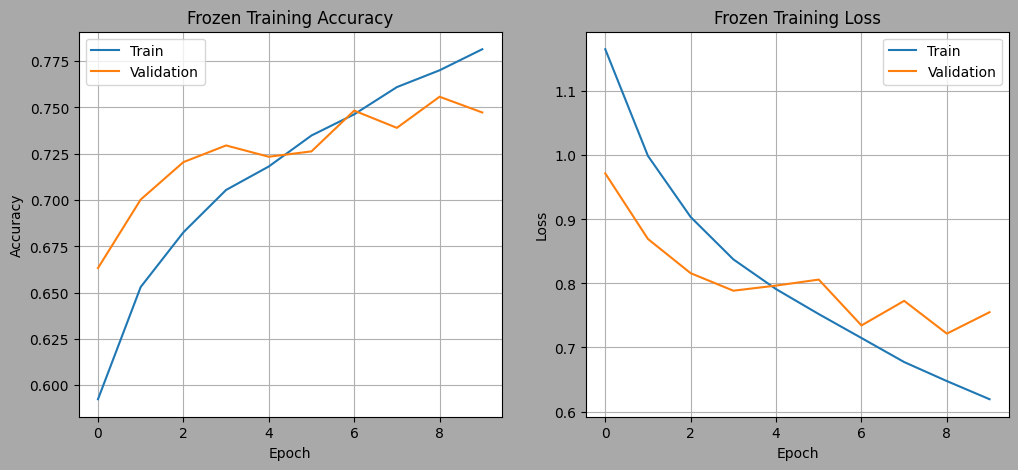

In [47]:
plt.figure(figsize=(12,5),facecolor="darkgray")

plt.subplot(1,2,1) # 1 row, 2 columns, this is the first graph of 2 ; ACCURACY
plt.plot(history_ft1.history["accuracy"])
plt.plot(history_ft1.history["val_accuracy"])
plt.title("Frozen Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(["Train","Validation"])

plt.subplot(1,2,2) # 1 row, 2 columns, this is the second graph of 2 ; LOSS
plt.plot(history_ft1.history["loss"])
plt.plot(history_ft1.history["val_loss"])
plt.title("Frozen Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend(["Train","Validation"])

plt.show()


In [46]:
def plot_accuracy_loss_check(history_model):

    plt.figure(figsize=(12,5),facecolor="darkgray")

    plt.subplot(1,2,1) # 1 row, 2 columns, this is the first graph of 2 ; ACCURACY
    plt.plot(history_model.history["accuracy"])
    plt.plot(history_model.history["val_accuracy"])
    plt.title("Frozen Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend(["Train","Validation"])

    plt.subplot(1,2,2) # 1 row, 2 columns, this is the second graph of 2 ; LOSS
    plt.plot(history_model.history["loss"])
    plt.plot(history_model.history["val_loss"])
    plt.title("Frozen Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend(["Train","Validation"])

    plt.show()



Ok now look closely:
- Training Accuracy up ; Training loss down ; But right now it isn't a stark contrast like upper 90s
- Val Accuracy has bumps ; Val Loss is kind of bumpy. 

**Could overfit, and that would be bad. So it is important that we use Early Stopping again. I think let's keep these frozen layers**

So let's not unfreeze more layers. That will for sure lead to more overfitting. Instead, let's do the same config with a lower learning rate and use Early Stopping

In [42]:
#recompile. Wait, it's already compiled and good to go 
history_careful = ani_model.fit(
    train_generator,
    epochs=15,  # Give it more epochs since LR is lower
    validation_data=val_generator,
    callbacks=[early_stop]
)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.7870 - loss: 0.6117 - val_accuracy: 0.7519 - val_loss: 0.7316
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.7935 - loss: 0.5804 - val_accuracy: 0.7576 - val_loss: 0.7320
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.8086 - loss: 0.5422 - val_accuracy: 0.7556 - val_loss: 0.7471
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.8151 - loss: 0.5261 - val_accuracy: 0.7574 - val_loss: 0.7415
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - accuracy: 0.8226 - loss: 0.4997 - val_accuracy: 0.7518 - val_loss: 0.7819
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - accuracy: 0.8346 - loss: 0.4715 - val_accuracy: 0.7523 - val_loss: 0.7691


Look at that. Stopped early. I think it is okay to deploy now. 

In [43]:
test_generator = test_datagen.flow(test_data,test_labels,
    batch_size=curr_batch_size,
    shuffle=False
)

In [44]:
import joblib

In [45]:
joblib.dump(ani_model,"ani_model_chkp_bump_26e.pkl")

['ani_model_chkp_bump_26e.pkl']

What now? We are 26 epochs in, and an overfitting pattern has been detected. val accuracy 75% and val loss 76%, and it is not going down further. 
We can either...
- Unfreeze and train more 
- Or deploy

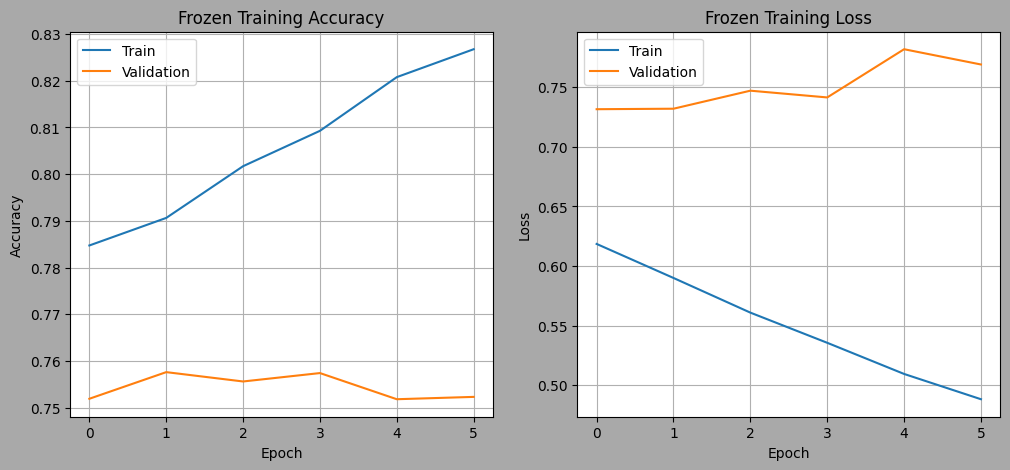

In [48]:
plot_accuracy_loss_check(history_careful)

Let's look at the trend all the way from pretrain to careful

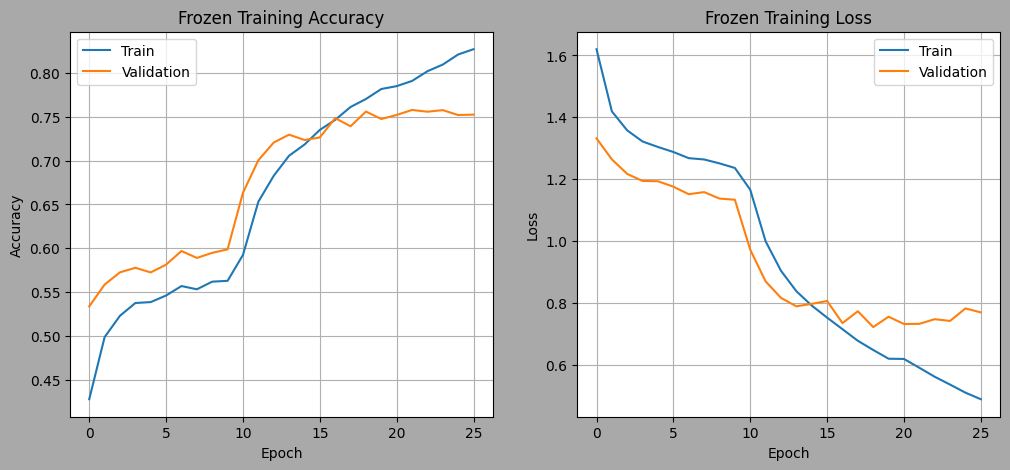

In [50]:
plt.figure(figsize=(12,5),facecolor="darkgray")

plt.subplot(1,2,1) # 1 row, 2 columns, this is the first graph of 2 ; ACCURACY
plt.plot(history_pretrain.history["accuracy"]+history_ft1.history["accuracy"]+history_careful.history["accuracy"])
plt.plot(history_pretrain.history["val_accuracy"]+history_ft1.history["val_accuracy"]+history_careful.history["val_accuracy"])
plt.title("Frozen Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(["Train","Validation"])

plt.subplot(1,2,2) # 1 row, 2 columns, this is the second graph of 2 ; LOSS
plt.plot(history_pretrain.history["loss"]+history_ft1.history["loss"]+history_careful.history["loss"])
plt.plot(history_pretrain.history["val_loss"]+history_ft1.history["val_loss"]+history_careful.history["val_loss"])
plt.title("Frozen Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend(["Train","Validation"])

plt.show()

# Step 6 : Deploy

We have this saved. We can train further later if we need, but right now, let's deploy to see if it is good how it is

In [51]:
pred_labels = ani_model.predict(test_generator)

/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 271ms/step


The predicted labels are no use to us as probabilites, which is what the .predict function will give us for this classification.

1. Convert Predictions to Class Labels

In [55]:
import numpy as np

In [56]:
#transform probabilities to predicted class indices 
pred_classes = np.argmax(pred_labels,axis=1)

2. Model Evaluation for the last metrics

In [57]:
[test_loss,test_accuracy] = ani_model.evaluate(test_generator)

79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 299ms/step - accuracy: 0.7488 - loss: 0.7452


3. Prepare True Labels for Classification Metrics

In [58]:
test_classes = np.argmax(test_labels,axis=1)

# Step 7 : Model Evaluation

In [59]:
from sklearn.metrics import confusion_matrix, classification_report

## Confusion Matrix

In [61]:
cm = confusion_matrix(test_classes,pred_classes)

In [64]:
import seaborn as sns

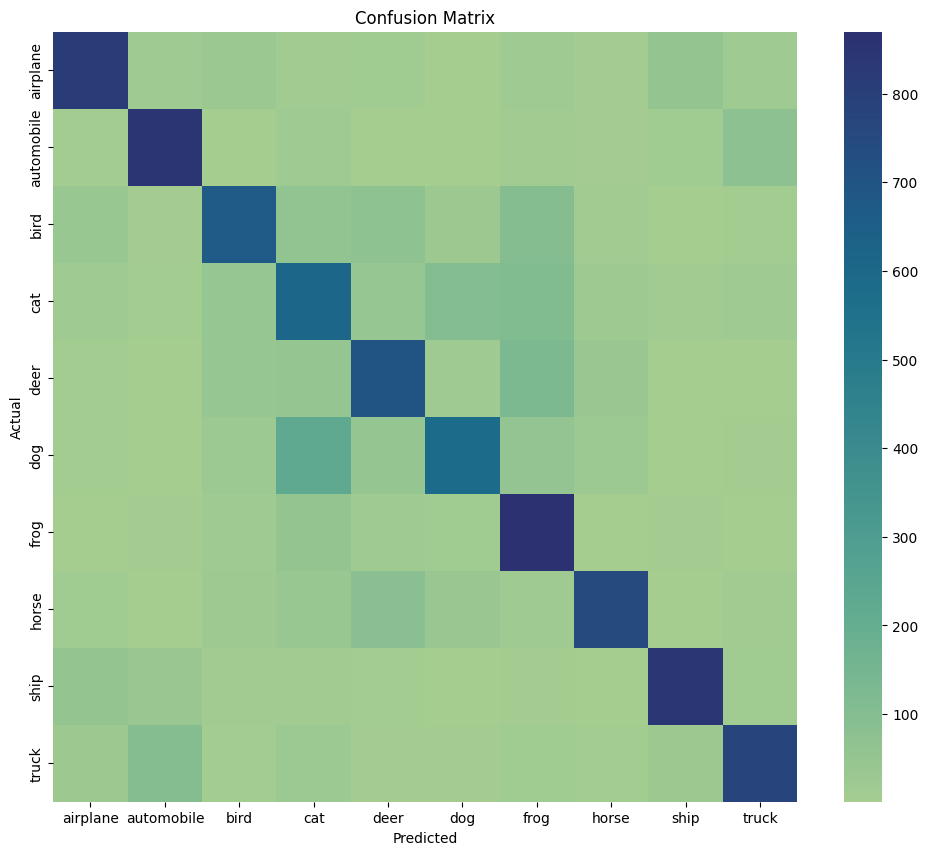

In [71]:
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                     'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(12,10))

sns.heatmap(cm,annot=False,cmap="crest",xticklabels=cifar10_classes,yticklabels=cifar10_classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

We observe many True positives. That is a good thing

In [81]:
print("Test Loss:",test_loss,"Test Accuracy:",test_accuracy)

Test Loss: 0.749870240688324 Test Accuracy: 0.7473999857902527


# Step 8 : Visualize Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Original label is cat and predicted label is cat


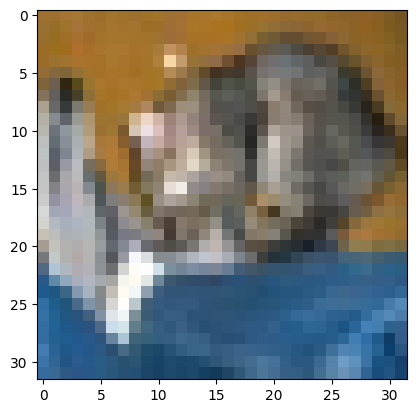

In [83]:
# label mapping
labels = '''airplane automobile bird cat deer dog frog horseship truck'''.split()

# select image from test data
image_number = 0

# display the image
plt.imshow(test_data[image_number])

# load the image in an array format
n = np.array(test_data[image_number])

# reshape it for the model prediction
p = n.reshape(1, 32, 32, 3) 

# pass in the network for prediction and 
# save the predicted label
predicted_label = labels[ani_model.predict(p).argmax()]

# load the original label
original_label = labels[test_classes[image_number]]

# display the result
print("Original label is {} and predicted label is {}".format(
    original_label, predicted_label))

Let's now be able to do that for any label in the test set

In [84]:
def visualize_prediction(img_num):
    # label mapping
    labels = '''airplane automobile bird cat deer dog frog horseship truck'''.split()

    # select image from test data
    image_number = img_num

    # display the image
    plt.imshow(test_data[image_number])

    # load the image in an array format
    n = np.array(test_data[image_number])

    # reshape it for the model prediction
    p = n.reshape(1, 32, 32, 3) 

    # pass in the network for prediction and 
    # save the predicted label
    predicted_label = labels[ani_model.predict(p).argmax()]

    # load the original label
    original_label = labels[test_classes[image_number]]

    # display the result
    print("Original label is {} and predicted label is {}".format(
        original_label, predicted_label))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Original label is airplane and predicted label is airplane


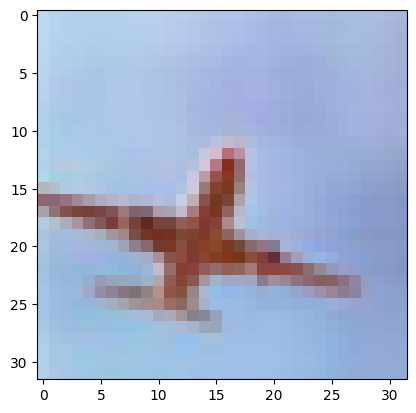

In [85]:
visualize_prediction(5722)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Original label is truck and predicted label is truck


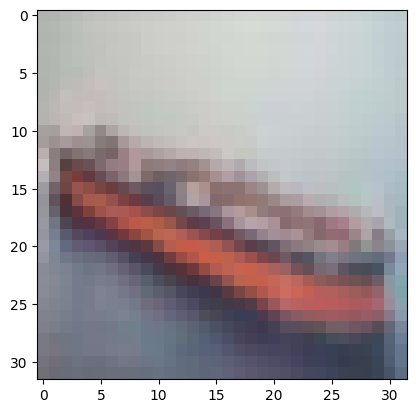

In [86]:
visualize_prediction(999)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Original label is truck and predicted label is truck


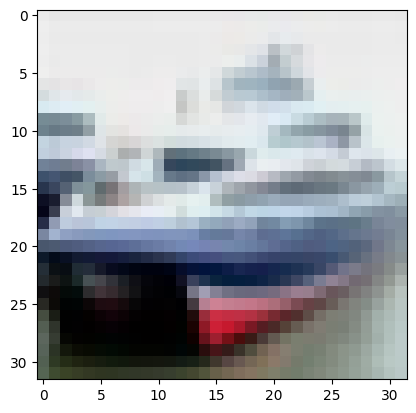

In [87]:
visualize_prediction(1)